# Análise de Amenities: Satisfação vs Preço

## Hipóteses:
**H1:** Quais amenities controláveis geram mais elogios?  
**H2:** Quais amenities estruturadas impactam mais o preço?

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Configurar estilo
plt.style.use('default')
sns.set_palette("husl")

# Carregar dados
listings = pd.read_csv('data/processed/listings.csv')
amenities_comments = pd.read_csv('data/processed/amenities_from_comments.csv')

In [92]:
# H1: Análise de Satisfação (Amenities dos Comentários)

# Amenities controláveis
controlable = ['wifi', 'tv', 'air conditioning', 'ac', 'kitchen', 'appliances', 
               'bed', 'bedding', 'linens', 'towels', 'cleaning', 'shower']

# Processar dados
df_h1 = amenities_comments[amenities_comments['item'].isin(controlable)]

# Calcular métricas por amenity
satisfaction_data = []
for amenity in df_h1['item'].unique():
    data = df_h1[df_h1['item'] == amenity]
    
    if len(data) >= 3:  # Mínimo 3 menções
        total = len(data)
        positive = len(data[data['sentiment'] == 'positive'])
        negative = len(data[data['sentiment'] == 'negative'])
        
        satisfaction_pct = (positive / total) * 100
        impact_score = satisfaction_pct * np.log(total + 1) * ((positive + negative) / total)
        
        satisfaction_data.append({
            'amenity': amenity,
            'total_mentions': total,
            'positive_count': positive,
            'negative_count': negative,
            'satisfaction_pct': satisfaction_pct,
            'impact_score': impact_score
        })

# Criar DataFrame
df_satisfaction = pd.DataFrame(satisfaction_data).sort_values('impact_score', ascending=False)

# Tabela H1
print("H1: Ranking de Satisfação")
satisfaction_table = df_satisfaction[['amenity', 'impact_score', 'satisfaction_pct', 'positive_count', 'total_mentions']].round(1)
satisfaction_table.columns = ['Amenity', 'Impact Score', 'Satisfação %', 'Elogios', 'Menções']
display(satisfaction_table.head(8))

H1: Ranking de Satisfação


,Amenity,Impact Score,Satisfação %,Elogios,Menções
0,kitchen,341.2,80.4,86,107
1,wifi,326.0,85.9,61,71
6,ac,204.7,88.9,8,9
7,tv,179.2,100.0,5,5
8,air conditioning,121.0,64.7,11,17
2,appliances,114.7,80.0,4,5
5,bedding,114.7,80.0,4,5
3,bed,102.3,66.7,6,9


In [93]:
# H2: Análise de Preço (Amenities Estruturadas)

# Pegar listings com dados da IA
listings_ai = amenities_comments['listing_id'].unique()
df_h2 = listings[listings['id'].isin(listings_ai)].dropna(subset=['price'])

# Função para extrair amenities
def extract_amenities(amenities_str):
    if pd.isna(amenities_str):
        return []
    try:
        if isinstance(amenities_str, str):
            amenities_list = ast.literal_eval(amenities_str)
        else:
            amenities_list = amenities_str
        return [amenity.lower().strip() for amenity in amenities_list]
    except:
        return []

# Processar amenities estruturadas
df_h2['amenities_processed'] = df_h2['amenities'].apply(extract_amenities)

# Encontrar amenities comuns
all_amenities = []
for amenities_list in df_h2['amenities_processed']:
    all_amenities.extend(amenities_list)

amenity_counts = pd.Series(all_amenities).value_counts()
common_amenities = amenity_counts[amenity_counts >= len(df_h2) * 0.1].index.tolist()

# Calcular impacto no preço
price_data = []
for amenity in common_amenities:
    df_h2[f'has_{amenity}'] = df_h2['amenities_processed'].apply(lambda x: amenity in x)
    
    with_amenity = df_h2[df_h2[f'has_{amenity}'] == True]['price']
    without_amenity = df_h2[df_h2[f'has_{amenity}'] == False]['price']
    
    if len(with_amenity) >= 10 and len(without_amenity) >= 10:
        median_with = with_amenity.median()
        median_without = without_amenity.median()
        impact_pct = ((median_with - median_without) / median_without) * 100
        diff_reais = median_with - median_without
        
        price_data.append({
            'amenity': amenity,
            'price_impact_pct': impact_pct,
            'diff_reais': diff_reais,
            'count_with': len(with_amenity),
            'median_with': median_with,
            'median_without': median_without
        })

# Criar DataFrame
df_price = pd.DataFrame(price_data).sort_values('price_impact_pct', ascending=False)

# Tabela H2
print("H2: Ranking de Impacto no Preço")
price_table = df_price[['amenity', 'price_impact_pct', 'diff_reais', 'count_with']].round(1)
price_table.columns = ['Amenity', 'Impacto %', 'Diferença R$', 'Propriedades']
display(price_table.head(8))

H2: Ranking de Impacto no Preço


,Amenity,Impacto %,Diferença R$,Propriedades
55,free dryer – in unit,43.6,200.0,57
67,cleaning available during stay,40.3,186.0,42
36,free parking on premises,34.4,155.0,101
64,mountain view,32.8,154.0,44
0,kitchen,29.1,110.5,352
66,dryer,28.8,137.0,42
46,free washer – in unit,27.6,127.0,76
54,host greets you,25.1,118.0,58


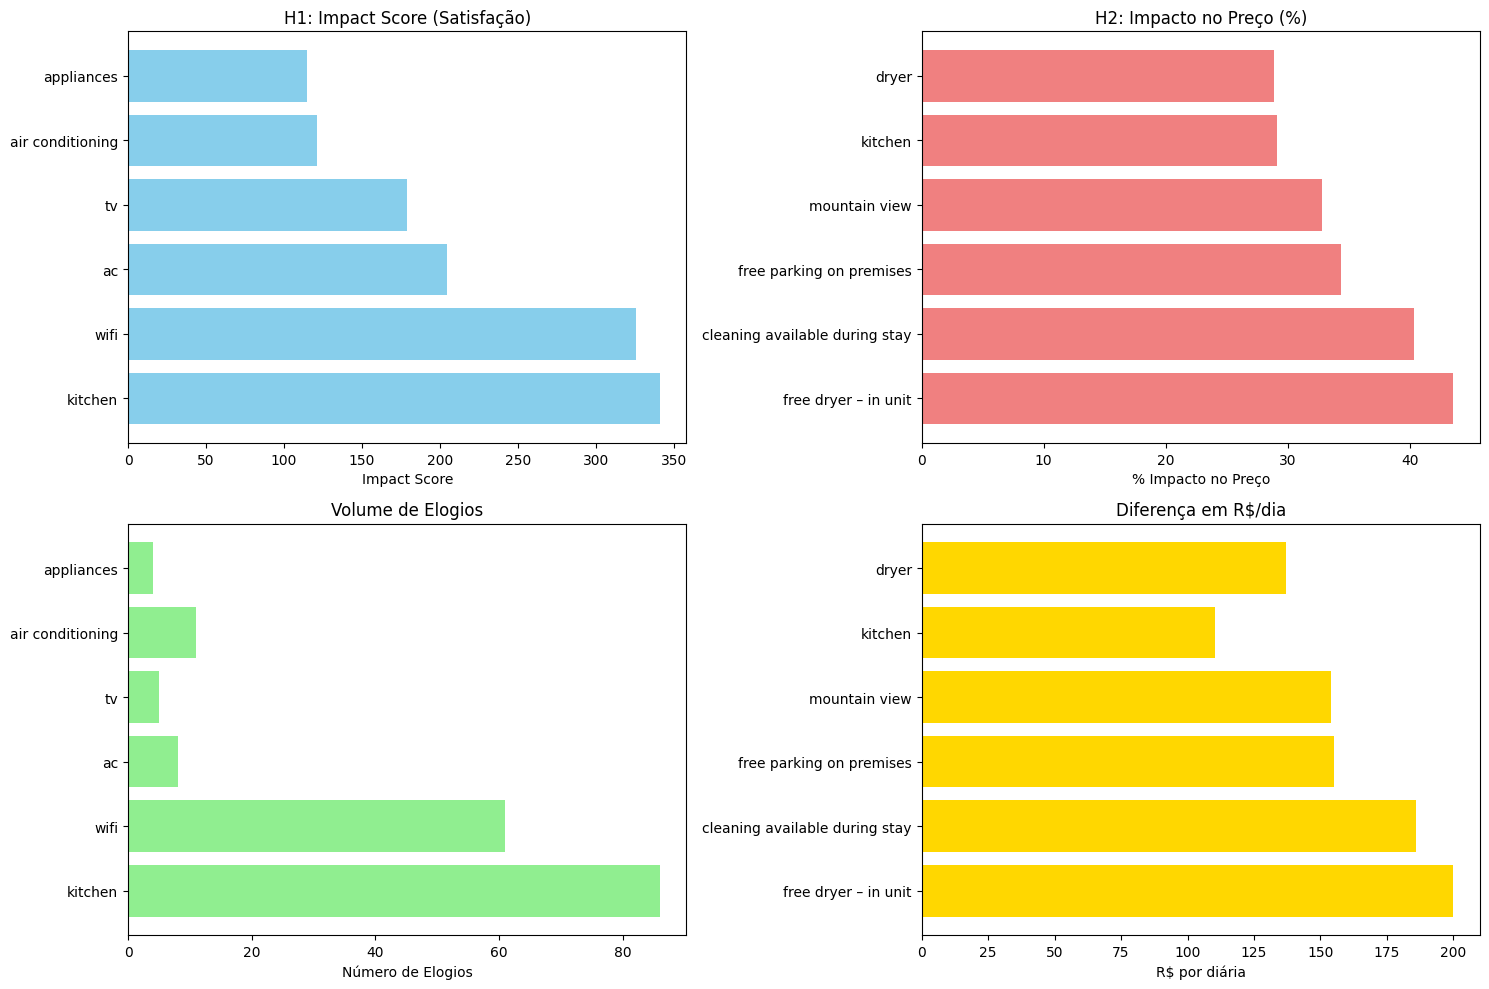

In [94]:
# Visualizações Comparativas

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Impact Score (Satisfação)
top_satisfaction = df_satisfaction.head(6)
ax1.barh(top_satisfaction['amenity'], top_satisfaction['impact_score'], color='skyblue')
ax1.set_title('H1: Impact Score (Satisfação)')
ax1.set_xlabel('Impact Score')

# 2. Impacto no Preço
top_price = df_price.head(6)
ax2.barh(top_price['amenity'], top_price['price_impact_pct'], color='lightcoral')
ax2.set_title('H2: Impacto no Preço (%)')
ax2.set_xlabel('% Impacto no Preço')

# 3. Volume de Elogios
ax3.barh(top_satisfaction['amenity'], top_satisfaction['positive_count'], color='lightgreen')
ax3.set_title('Volume de Elogios')
ax3.set_xlabel('Número de Elogios')

# 4. Diferença em Reais
ax4.barh(top_price['amenity'], top_price['diff_reais'], color='gold')
ax4.set_title('Diferença em R$/dia')
ax4.set_xlabel('R$ por diária')

plt.tight_layout()
plt.show()

In [95]:
# Comparação Direta: Satisfação vs Preço

# Criar tabela comparativa
comparison_data = {
    'Ranking Satisfação': [f"{i+1}. {row['amenity']} ({row['impact_score']:.0f})" 
                          for i, row in df_satisfaction.head(5).iterrows()],
    'Ranking Preço': [f"{i+1}. {row['amenity']} (+{row['price_impact_pct']:.0f}%)" 
                     for i, row in df_price.head(5).iterrows()]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

,Ranking Satisfação,Ranking Preço
0,1. kitchen (341),56. free dryer – in unit (+44%)
1,2. wifi (326),68. cleaning available during stay (+40%)
2,7. ac (205),37. free parking on premises (+34%)
3,8. tv (179),65. mountain view (+33%)
4,9. air conditioning (121),1. kitchen (+29%)


In [96]:
# Insights-Chave

# Métricas de performance relativa
media_elogios = df_satisfaction['positive_count'].mean()
wifi_data = df_satisfaction[df_satisfaction['amenity'] == 'wifi']

insights_data = []

# WiFi vs média
if len(wifi_data) > 0:
    wifi_elogios = wifi_data.iloc[0]['positive_count']
    multiplicador = wifi_elogios / media_elogios
    insights_data.append({
        'Métrica': 'WiFi vs Média de Elogios',
        'Valor': f"{multiplicador:.1f}x mais elogios",
        'Detalhes': f"{wifi_elogios} vs {media_elogios:.1f}"
    })

# Top performers
if len(df_satisfaction) > 0:
    top_sat = df_satisfaction.iloc[0]
    insights_data.append({
        'Métrica': 'Melhor Satisfação',
        'Valor': f"{top_sat['amenity']} ({top_sat['impact_score']:.0f} pts)",
        'Detalhes': f"{top_sat['positive_count']} elogios, {top_sat['satisfaction_pct']:.0f}%"
    })

if len(df_price) > 0:
    top_price = df_price.iloc[0]
    insights_data.append({
        'Métrica': 'Melhor Preço',
        'Valor': f"{top_price['amenity']} (+{top_price['price_impact_pct']:.0f}%)",
        'Detalhes': f"+R${top_price['diff_reais']:.0f}/dia"
    })

# Eficiência (elogios por menção)
df_satisfaction['eficiencia'] = df_satisfaction['positive_count'] / df_satisfaction['total_mentions']
most_efficient = df_satisfaction.sort_values('eficiencia', ascending=False).iloc[0]
insights_data.append({
    'Métrica': 'Mais Eficiente',
    'Valor': f"{most_efficient['amenity']} ({most_efficient['eficiencia']:.2f})",
    'Detalhes': f"{most_efficient['positive_count']} elogios / {most_efficient['total_mentions']} menções"
})

insights_df = pd.DataFrame(insights_data)
display(insights_df)

,Métrica,Valor,Detalhes
0,WiFi vs Média de Elogios,3.5x mais elogios,61 vs 17.5
1,Melhor Satisfação,kitchen (341 pts),"86 elogios, 80%"
2,Melhor Preço,free dryer – in unit (+44%),+R$200/dia
3,Mais Eficiente,tv (1.00),5 elogios / 5 menções


In [97]:
# Conclusões

# Resposta às hipóteses
results_data = []

# H1: Satisfação
if len(df_satisfaction) > 0:
    winner_h1 = df_satisfaction.iloc[0]
    results_data.append({
        'Hipótese': 'H1: Satisfação',
        'Resultado': f"{winner_h1['amenity']} lidera",
        'Evidência': f"{winner_h1['impact_score']:.0f} impact score, {winner_h1['positive_count']} elogios"
    })

# H2: Preço
if len(df_price) > 0:
    winner_h2 = df_price.iloc[0]
    results_data.append({
        'Hipótese': 'H2: Preço', 
        'Resultado': f"{winner_h2['amenity']} lidera",
        'Evidência': f"+{winner_h2['price_impact_pct']:.0f}% (+R${winner_h2['diff_reais']:.0f}/dia)"
    })

# Recomendação
if len(df_satisfaction) > 0 and len(df_price) > 0:
    sat_winner = df_satisfaction.iloc[0]['amenity']
    price_winner = df_price.iloc[0]['amenity']
    
    if sat_winner.lower() == price_winner.lower():
        recommendation = f"Investir em {sat_winner}: vence em satisfação E preço"
    else:
        recommendation = f"Para satisfação: {sat_winner} | Para receita: {price_winner}"
    
    results_data.append({
        'Hipótese': 'Recomendação',
        'Resultado': recommendation,
        'Evidência': 'Baseado em análise comparativa'
    })

results_df = pd.DataFrame(results_data)
display(results_df)

,Hipótese,Resultado,Evidência
0,H1: Satisfação,kitchen lidera,"341 impact score, 86 elogios"
1,H2: Preço,free dryer – in unit lidera,+44% (+R$200/dia)
2,Recomendação,Para satisfação: kitchen | Para receita: free ...,Baseado em análise comparativa


In [98]:
# Estatísticas Finais

# Resumo dos dados analisados
stats_data = [
    ['Total comentários processados', len(amenities_comments)],
    ['Amenities controláveis analisadas', len(df_satisfaction)],
    ['Amenities estruturadas analisadas', len(df_price)],
    ['Listings com preço válido', len(df_h2)],
    ['Média elogios por amenity', f"{media_elogios:.1f}"],
    ['WiFi vs média', f"{wifi_elogios/media_elogios:.1f}x" if len(wifi_data) > 0 else 'N/A']
]

stats_df = pd.DataFrame(stats_data, columns=['Métrica', 'Valor'])
display(stats_df)

,Métrica,Valor
0,Total comentários processados,621
1,Amenities controláveis analisadas,11
2,Amenities estruturadas analisadas,72
3,Listings com preço válido,362
4,Média elogios por amenity,17.5
5,WiFi vs média,3.5x
